In [ ]:
%pip install -r crewai-requirements.txt --upgrade --quiet
%pip install openlit duckduckgo_search sagemaker-mlflow mlflow sagemaker --upgrade --quiet

In [ ]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

# CrewAI Observability with MLFlow
Observability is essential for understanding, debugging, and optimizing multi-agent AI systems, especially as they become more complex and are deployed in production environments. By leveraging SagemakerAI MLflow’s tracking and tracing capabilities, you gain detailed visibility into agent executions, tool usage, LLM calls, and the overall orchestration of tasks.

SageMakerAI MLflow, provides a secure, scalable backend for logging experiment metadata, traces, and custom attributes. This enables you to analyze agent behaviors, performance bottlenecks, and workflow interactions through an intuitive UI. The integration supports both automatic and manual tracing, allowing you to capture everything from high-level task flows to granular tool invocations. This observability is critical for ensuring reproducibility, diagnosing issues, and continuously improving your CrewAI-based solutions.

## Overview
In this notebook, you will configure and use MLflow with Amazon SageMaker to monitor and trace CrewAI agent workflows. The integration enables you to:

Automatically log agent actions, tool calls, and LLM invocations with minimal code changes.

Use MLflow’s tracing UI to visualize execution trees, analyze performance, and debug complex workflows.

Add custom metadata to traces for deeper insights and easier filtering.

Organize and compare runs under different experiments for structured analysis.

You will set up the MLflow tracking server on SageMaker, configure your CrewAI workflow to report to it, and use MLflow’s decorators and autologging features to capture detailed traces of agent operations. This approach ensures that every step in your multi-agent orchestration is observable, from input queries to final outputs, supporting both development and production monitoring needs.

## Prerequisites

Before starting this notebook, ensure you have:
- Basic understanding of Python and Jupyter notebooks
- AWS account with access to Amazon Bedrock and SageMaker
- If this is run as part of the AWS workshop, ensure previous section of the workshop labs are complete.
- Access to AWS Account, and SageMakerAI Studio. See [AWS instructions here](https://docs.aws.amazon.com/sagemaker/latest/dg/onboard-quick-start.html) if you want to get started with SageMakerAI Studio quickly.
- Setup and launch **SageMakerAI MLFlow**. See [AWS instructions here](https://docs.aws.amazon.com/sagemaker/latest/dg/mlflow-launch-ui.html) 
- See below for a sample IAM policy which the IAM role will need to use SageMaker MLFLow (Like for tracing). For more on SageMaker MLFlow's IAM details see [AWS IAM documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/mlflow-create-tracking-server-iam.html)

```
{
    "Version": "2012-10-17",    
    "Statement": [        
        {            
            "Effect": "Allow",            
            "Action": "sagemaker-mlflow:*",            
            "Resource": "*"        
        }        
    ]
}
```

- You will need to note down the `SageMaker MLFlow tracing server ARN` and use it in the notebooks. You can quickly copy the ARN on sagemakerAI studio by clicking the copy icon on you MLFlow 

## SageMakerAI MLFlow
We will configure MLflow integration with Amazon SageMaker for tracking and tracing agent-based workflows. Frist we establishes a connection to a specific SageMakerAI MLflow Tracking Server using an ARN (Amazon Resource Name). 
The `mlflow.set_tracking_uri()` method directs all subsequent MLflow logging operations to this server, ensuring experiment metadata is stored in the secure backend maintained by SageMaker.

Importantly, `mlflow.crewai.autolog()` activates automatic logging of crewai components, capturing executions, prompts, LLM calls, and other interactions without requiring manual instrumentation. This configuration enables comprehensive tracking of ML experiments with minimal additional code, allowing data scientists to focus on their workflows while maintaining detailed logs for later analysis and reproducibility.

The import of `SpanType` from MLflow entities enables detailed tracing of agent workflows, allowing the categorization of different operation types (agent actions, tool calls, LLM invocations) in the execution tree. 

(Optional) You can organize all your MLFlow observibility data by setting `mlflow.set_experiment("<YOUR_MLFLOW_EXPERIMENT_NAME>")`. Using which MLflow allows you to group runs under experiments, which can be useful for comparing runs intended to tackle a particular task.

In [ ]:
import mlflow
from mlflow.entities import SpanType

%store -r tracking_server_arn
_MLFLOW_URI = tracking_server_arn
mlflow.set_tracking_uri(_MLFLOW_URI)
# enable automatic logging of traces
mlflow.crewai.autolog()

## Start tracing!

In [ ]:
from crewai import LLM

model = LLM(
    # model="sagemaker/INSERT ENDPOINT NAME",
    model="bedrock/us.amazon.nova-pro-v1:0",
    temperature=0.7, max_tokens=4*1024,
)

## Add tool and detailed tracing for the tool with MLFlow custom trace decorators

Next, you will create a tool and add MLFlow's custom decorators `@mlflow.trace()`. 
While you can trace without the decorator, this custom decorators tracing configuration is particularly useful for performance analysis and debugging multi-agent orchestration systems. When applied to functions representing agent operations it provides two important capabilities:
- Setting span_type=SpanType.AGENT tells MLflow that this span represents an agent's activity within your workflow. When visualized in MLflow's tracing UI, spans with this type will be categorized and displayed distinctly from other operation types (like tools or LLM calls). Different types of span are: `SpanType.TOOL` A tool call (e.g., Google Search), `SpanType.LLM` An LLM model invocation (e.g., generating text) and `SpanType.CHAIN` A sequence of steps (e.g., the whole pipeline).
- The `attributes={"workflow": "agent_tool_search"}` parameter adds a custom metadata tag to the span. These custom attributes are extremely valuable when you have complex multi-agent systems with Associate spans with: specific workflow components, Filter traces by workflow stage during debugging, Add domain-specific metadata to your traces

When applied this decorator would track:
- Input: The user's query from the Streamlit app
- Processing: Time spent on analysis
- Tool usage: Web search calls (which would appear as child spans)
- Output: The research results passed to Agent 2

This tracing configuration is particularly useful for performance analysis and debugging custom logic or other orchestration systems.


In [ ]:
from crewai_tools import SerperDevTool
from crewai.tools import tool
from duckduckgo_search import DDGS
import os

load_dotenv()

@tool('DuckDuckGoSearch')
@mlflow.trace(attributes={"workflow": "agent_tool_search"}, span_type=SpanType.TOOL)
def search_with_duckduckgo(search_query: str):
    """Search the web for information on a given topic"""
    return DDGS().text(search_query, max_results=5)

if os.environ.get("SERPER_API_KEY"):
    search_tool = SerperDevTool()
    print("Using Serper API for search")
else:
    search_tool = search_with_duckduckgo
    print("No Serper API Key found - Using DuckDuckGo API for search")

In [ ]:
from crewai import Agent, Task, Crew

writer = Agent(
        role="Writer",
        goal="You make math engaging and understandable for young children through poetry",
        backstory="You're an expert in writing haikus but you know nothing of math.",
        tools=[search_tool],
        llm=model
    )

task = Task(description=("What is {topic}?"),
            expected_output=("Compose a short poem that includes the answer."),
            agent=writer)

crew = Crew(
  agents=[writer],
  tasks=[task],
  share_crew=False
)

result = crew.kickoff({"topic": "Amazon Bedrock"})
print(result)

### Open you SageMaker MLFlow UI and see the tracing tab to the outputs
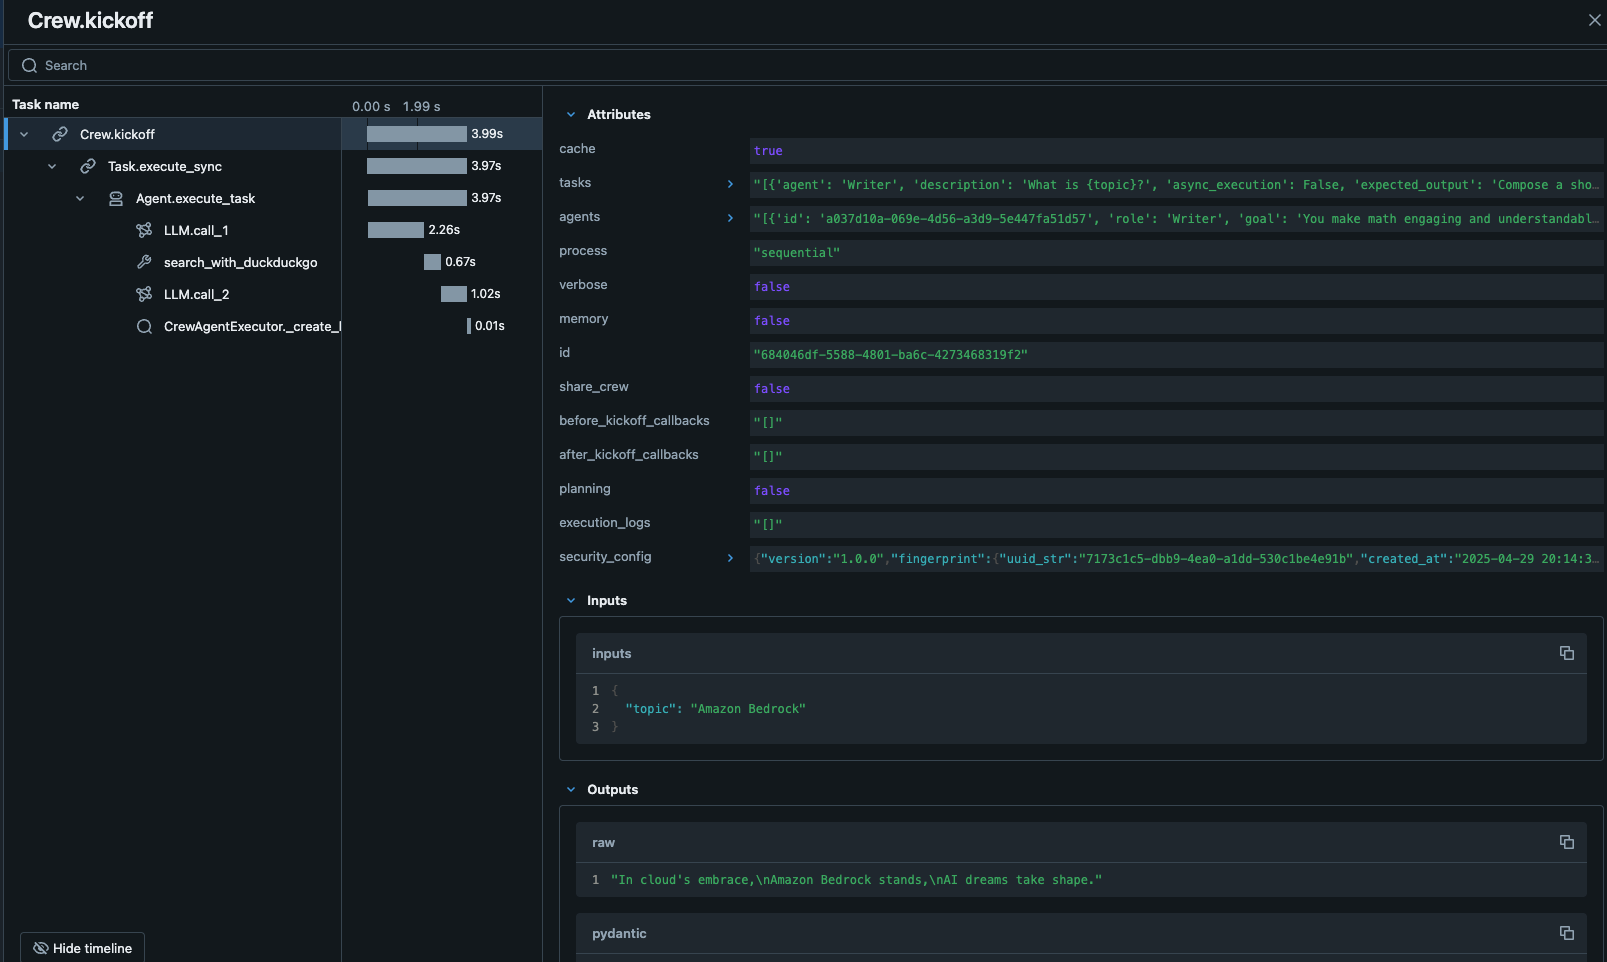

---

## Summary

In this notebook, you've learned how to:

1. Enable observibility for agents using SageMaker MLFlow
2. Create and trace crewai agent using Sagemaker MLFlow